###### Compte rendu

# Classification de vêtements en Machine Learning

![](https://storage.googleapis.com/kaggle-datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png)

## Problématique
L'objectif de notre projet est de classifier les différentes images de la base MNIST de TensorFlow. Pour cela nous allons utiliser la méthode de machine learning `Bag of Word` suivi du `K-means` avec les SIFT (Scale-Invariant Feature Transform) présents dans les différentes images d'une base de données d'entrainement. 

Ce Notebook va nous permettre a la fois d'expliquer la démarche théorique tout en la mettant en pratique

## Réalisation
Dans cette partie nous allons expliquer en détail les différentes étapes menant à la réalisation de cette classification d'image.

SIFT (Scale-Invariant Feature Transform) est un algorithme utilisé dans le domaine de la vision par ordinateur pour détecter et identifier les éléments similaires entre différentes images numériques. Un point clé SIFT contient un descripteur qui apparaîtra également dans des images similaires (Exemple: 2 photos d'un livre prises sous des angles différents).

Les descripteurs SIFT générer depuis toutes les images d'entrainements permettront à l'aide de la méthode K-means de définir les 70 descripteurs les plus couramment apparu et d'associé un de ces derniers à chaque point SIFT d'une nouvelle image. Ceci est la méthode Bag Of Word qui consiste dans notre cas à définir chaque éléments dans un ensemble de descripteur fini.

![gateau](https://ianlondon.github.io/images/oct_output_8_0.png)
<center><i>Points SIFT reliés de deux photos d'un octopus prises sous un angle différent</i></center>

### Importation des librairies

In [1]:
%matplotlib inline
# Matplotlib (2.2.3): Permet la génération le rendu de graphique et d'images
import matplotlib.pyplot as plt

# Tensorflow (2.0.0): Librairie de Deep Learning, dont nous allons utiliser la base d'images MNIST
import tensorflow as tf

# Numpy (1.17.3): Calculs mathématique
import numpy as np

# OpenCV (3.4.2): Librairie spécialisée dans le traitement d'images
import cv2

### Récupération des images et création de base d'entrainements et de tests depuis MNIST

In [2]:
# Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(images, targets), (images_test, targets_test) = fashion_mnist.load_data()

# Sélection d'une sous-partie des datas
images = images[:10000]
targets = targets [:10000]
targets_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
                 "Shirt", "Sneaker", "Bag", "Ankle boot"]


### Définition des méthodes permettant de générer les points clés et de les afficher

In [3]:
# Modification des paramètres nfeatures et contrastThreshold afin d'avoir un maximum de points clés
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000, contrastThreshold=0)

def gen_sift_features(gray_img):
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

### Génération des points clés pour une image et affichage

Nombre de points clés :  91
Voici le résultat :


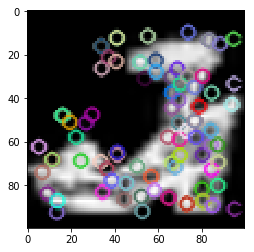

In [4]:
image_id = 60

images_0 = cv2.resize(images[image_id], (100, 100))
images_0_kp, images_0_desc = gen_sift_features(images_0)

print("Nombre de points clés : ", len(images_0_kp))
print('Voici le résultat :')
show_sift_features(images_0, images_0, images_0_kp);

### Redimensionnement de toutes les images afin d'avoir plus de points clés
On passe d'images de dimension 28x28 à 100x100 pixels

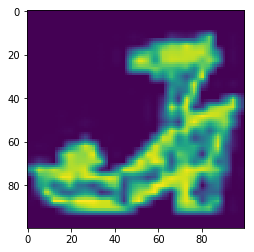

In [5]:
images = [cv2.resize(I, (100, 100)) for I in images]
images = np.asarray(images)

images_test = [cv2.resize(I, (100, 100)) for I in images_test]
images_test = np.asarray(images_test)

plt.imshow(images[image_id])

### Regroupement de toutes les données (tableau de points clés et description) de toutes les images dans un tableau
*environs 1min de traitement*

In [6]:
all_samples = [gen_sift_features(I) for I in images]
all_samples = np.asarray(all_samples)

### Regroupement de toutes les descriptions en un tableau

In [7]:
desc_samples = [ np.asarray(sample[1]) for sample in all_samples]
element_to_remove = []
for i in range(len(desc_samples)):
    if len(desc_samples[i].shape) != 2:
        element_to_remove.append(i)
        print("error matrix number ", i)
        
for i in range(len(element_to_remove)):
    del desc_samples[element_to_remove[i] - i]
        
desc_samples = np.vstack(desc_samples)

### Sélection de 100 000 descriptions à partir desquelles se fera l'apprentissage

In [8]:
s = np.random.choice(desc_samples.shape[0], 100000, replace = False)

desc_samples = desc_samples[s,: ]

### Calcul des descripteur les plus courants à l'aide de la méthode K-MEANS
*environs 40sec de traitement*

In [9]:
from sklearn.cluster import KMeans
kms = KMeans(70, n_init=1).fit(desc_samples)
bins = kms.cluster_centers_.astype(np.uint8)

### Définition de la fonction permettant d'avoir le pourcentage d'apparition de chaque mots dans une image
Association de chaque descripteurs de l'image à un des descripteurs de notre `K-means` que nous appelons aussi "mot"

In [10]:
def compute_hist(kmeans, I):
    histogram = np.zeros(len(kmeans.cluster_centers_))
    I_kp, I_desc = gen_sift_features(I)
    I_desc = np.asarray(I_desc)
    quantification = kmeans.predict(I_desc)
    index, value = np.unique(quantification, return_counts = True)
    histogram[index] = value
    return histogram/np.sum(histogram).astype(np.float32)

### Exemple : Affichage de l'histogramme générer pour une image de notre base

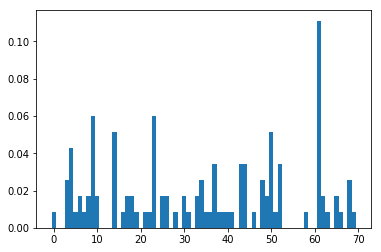

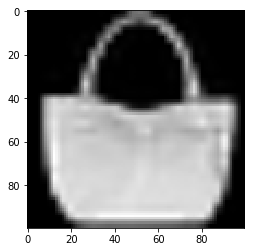

In [11]:
im = images[100]
histo = compute_hist(kms, im)
palette = kms.cluster_centers_.astype(np.uint8)

plt.figure()
plt.bar(range(len(histo)),histo, width = 1, edgecolor = 'none')
plt.figure()
plt.imshow(im, cmap="gray")


### Calcul de l'histogramme pour toutes les images de tests
*environs 1min de traitement*

In [12]:
X_test = np.zeros((len(images_test), kms.n_clusters))
for i in range(len(images_test)):
    try:
        X_test[i,:] = compute_hist(kms, images_test[i])
    except:
        print("Error : ", i)

### Calcul de l'histogramme pour toutes les images d'entrainements
*environs 1min de traitement*

In [13]:
X_images = np.zeros((len(images), kms.n_clusters))
for i in range(len(images)):
    try:
        X_images[i,:] = compute_hist(kms, images[i])
    except:
        print("Error : ", i)

### Calcul de la matrice de distance
Cette matrice de distance va nous permettre d'utiliser la méthode des K-plus proche voisins. Plus la distance est courte, plus les histogrames se ressemblent, ce qui induit que les images correspondantes seraient similaires.

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(X_test, X_images)

### Affichage des 15 habits les plus proches pour une images de la base de test

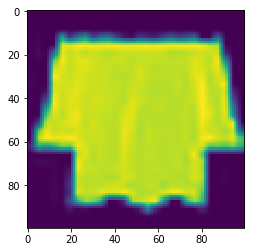

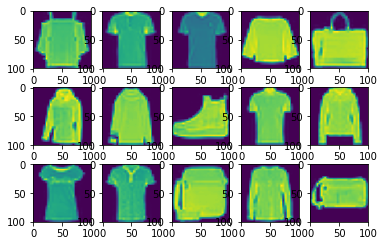

In [15]:
image_test_id = 5002
similar_image_position = np.argsort(dist[image_test_id])

plt.figure()
plt.imshow(images_test[image_test_id])
plt.figure()
for i in range(1,16):
    plt.subplot(3,5,i)
    plt.imshow(images[similar_image_position[i]])

### Détermination du label à l'aide des K plus proche voisins

In [16]:
# Nombre de voisin que l'on veut analyser
nb_nn = 30


nb_nn += 1
result = np.zeros(10)
for i in range(1,nb_nn):
    result[targets[similar_image_position[i]]] += 1
    
print(result)
print("Real : " ,targets_names[targets_test[image_test_id]])
print("Predicted : ", targets_names[np.argmax(result)])

[13.  0.  3.  0.  5.  0.  4.  0.  3.  2.]
Real :  Shirt
Predicted :  T-shirt/top


### Calcul du pourcentage de réussite sur notre base de test

In [17]:
nb_true = 0
t = np.zeros(len(images_test))

for i in range(len(images_test)):
    image_test_id = i
    similar_image_position = np.argsort(dist[image_test_id])
    
    result = np.zeros(10)
    for k in range(1, nb_nn):
        result[targets[similar_image_position[k]]] += 1
        
    if(np.argmax(result) == targets_test[i]): 
        nb_true += 1
        t[i] = 1
    
print("Global accuracy : {0:.3f}".format((nb_true/len(images_test))))

Global accuracy : 0.473


### Calcul du pourcentage de réussite en fonction du vêtement

In [18]:
nb_targets = np.zeros(10)
nb_good_answers = np.zeros(10)

for i in range(len(t)):
    nb_targets[targets[i]] += 1
    if(t[i] == 1): nb_good_answers[targets[i]] += 1

taux = nb_good_answers / nb_targets

In [19]:
for i in range(len(targets_names)):
    print("{0} : {1:.3f}".format(targets_names[i], taux[i]))

T-shirt/top : 0.516
Trouser : 0.467
Pullover : 0.474
Dress : 0.452
Coat : 0.501
Sandal : 0.475
Shirt : 0.439
Sneaker : 0.472
Bag : 0.470
Ankle boot : 0.472


### Les paramètres modifiables

Lors de nos tests la précision globale était d'environ **48%**. Bien entendu pour parvenir à ce résultat nous avons dû "jouer" avec certains paramètres.

Nous avons joué avec les différents paramètres suivant : 
- La dimension des images (100 x 100)
- Le nombre de descripteurs (70)
- Le nombre de voisins à prendre en compte pour la labellisation (30)

### Test sur des images prises sur internet

La fonction `get_label` permet d'avoir pour une image, la prédiction de son label et le pourcentage de cette prédicition.

In [20]:
def get_label(image):
    image = cv2.resize(image, (100, 100))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = 255 - image
    
    X_image = np.zeros((1, kms.n_clusters))
    X_image[0] = compute_hist(kms, image)

    dist_with_image = euclidean_distances(X_image, X_images)
    similar_image_position = np.argsort(dist_with_image[0])
    
    result = np.zeros(10)
    for i in range(1,nb_nn):
        result[targets[similar_image_position[i]]] += 1
    
    return [np.argmax(result), max(result)/ nb_nn]

In [21]:
filenames = ["image_chaussure.png",
            "image_chaussure_2.png",
            "image_bag.png",
            "image_ankle_boot.png",
            "image_coat.png",
            "image_dress.png",
            "image_sandal.png",
            "image_t_shirt.png",
            "image_trouser.png",
            "image_pullover.png"]

Les images du talon et du pantalon sont souvent bien labellisés avec une haute certitude.

In [22]:
for i in range(len(filenames)): 
    filename = "./images/" +filenames[i]
    label = get_label(cv2.imread("./" + filename))
    print("{0} --> {1} : {2:.3f}".format(filename, targets_names[label[0]], label[1]))

./images/image_chaussure.png --> Sneaker : 0.323
./images/image_chaussure_2.png --> Bag : 0.387
./images/image_bag.png --> Ankle boot : 0.419
./images/image_ankle_boot.png --> Ankle boot : 0.871
./images/image_coat.png --> Coat : 0.452
./images/image_dress.png --> Shirt : 0.258
./images/image_sandal.png --> Bag : 0.290
./images/image_t_shirt.png --> Ankle boot : 0.290
./images/image_trouser.png --> Trouser : 0.903
./images/image_pullover.png --> Shirt : 0.258
